## Import libraries

In [ ]:
!pip install hmmlearn
import numpy as np
from hmmlearn import hmm
import pandas as pd
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import yfinance as yf
yf.pdr_override()

## Fetch data


### VSTOXX

https://www.stoxx.com/data-index-details?symbol=V2TX -> EUR Price (.txt)

In [ ]:
df = pd.read_csv('VSTOXX.txt', sep=';')
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y')  # Adjust the date format
# Set 'Date' as the index of the DataFrame
df.set_index('Date', inplace=True)
start_date = '2021-01-01'
end_date = '2024-04-27'
VSTOXX = df.loc[start_date:end_date]['Indexvalue']

### Yahoo data

In [ ]:
SPX = pdr.get_data_yahoo('^SPX', start='2021-01-01', end='2024-04-27')['Close']
VIX = pdr.get_data_yahoo('^VIX', start='2021-01-01', end='2024-04-27')['Close']
STOXX50E = pdr.get_data_yahoo('^STOXX50E', start='2021-01-01', end='2024-04-27')['Close']

## Parameter learning

###Discrete

In [ ]:
# Replace with desired dataset
data = VIX

In [ ]:
# Define threshold and categorize/discretize the data // Data preparation
# Simple example; can be customized freely

# Uncomment if interested in daily pct_change and/or absolute pct_change
# data = data['Close'].pct_change() * 100
# data = abs(data) #
threshold = (np.max(data)+np.min(data))*0.5
observations = [1 if n >= threshold else 0 for n in data]
observations = np.array(observations).reshape(-1, 1)

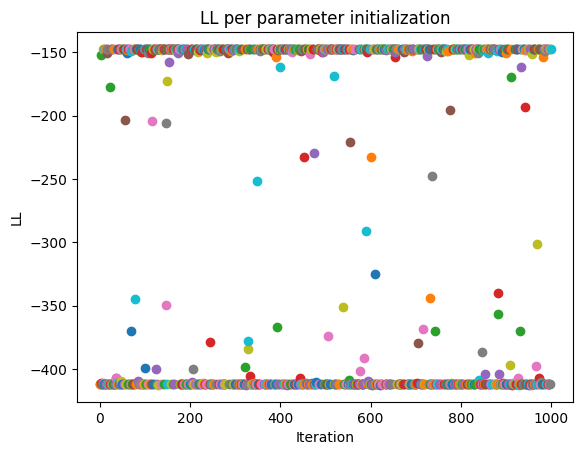

In [ ]:
# Parameter Estimation for discrete models

best_bic = np.inf
bics = [] # for BIC plot
for n in range(5):
  best_LL = -np.inf
  best_model = None

  # Parameter estimation for n_states
  n_states = n+1
  for i in range(1000):
    model = hmm.CategoricalHMM(n_components = n_states).fit(observations)
    LL = model.score(observations)
    # Save best scoring model
    if LL > best_LL:
        best_LL = LL
        best_model = model
    # Save iteration to plot if optimal n_states
    if n_states == 2: # replace for optimal n_states (might need to re-run)
      plt.scatter(y=LL, x=i)

  # Calculate BIC value and append for plot
  n_params = n_states * (n_states - 1) + n_states + (n_states - 1)
  n_samples = len(data)
  BIC = -2 * best_LL + n_params * np.log(n_samples)
  bics.append(BIC)

  # If BIC of n_states is lower than current best -> replace
  if BIC < best_bic:
    best_bic = BIC
    optimal_states = n_states
    optimal_model = best_model
    optimal_LL = best_LL

# Plot log-likelihood for optimal n_states
plt.title('LL per parameter initialization')
plt.xlabel('Iteration')
plt.ylabel('LL')
plt.show()

In [ ]:
# Print BIC, LL, and number of states for the optimal model
print(f'BIC: {best_bic}')
print(f'Log-likelihood: {optimal_LL}\nStates: {optimal_states}')

BIC: 328.6387708122378
Log-likelihood: -147.50380190022204
States: 2


In [ ]:
# Print TPM and CPM of the optimal model
print(f'Transition Probability Matrix (TPM): \n {optimal_model.transmat_}')
print(f'Emission Probabilities (CPM): \n {optimal_model.emissionprob_}')

Transition Probability Matrix (TPM): 
 [[0.98420799 0.01579201]
 [0.06741441 0.93258559]]
Emission Probabilities (CPM): 
 [[0.99434258 0.00565742]
 [0.06384264 0.93615736]]


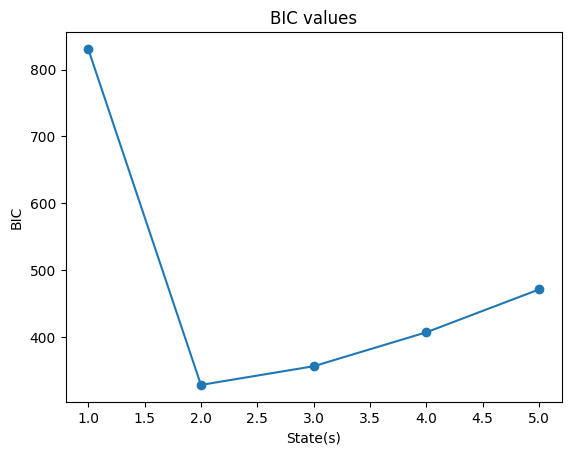

In [ ]:
# Plot BIC values for different n_states
plt.scatter(range(1,len(bics)+1), bics)
plt.plot(range(1,len(bics)+1), bics)
plt.title('BIC values')
plt.ylabel('BIC')
plt.xlabel('State(s)')
plt.show()

###Gaussian

In [ ]:
# Replace with desired dataset
data = STOXX50E

In [ ]:
# Data preparation
data = data.pct_change()*100
dataset = np.column_stack([data[1:]])

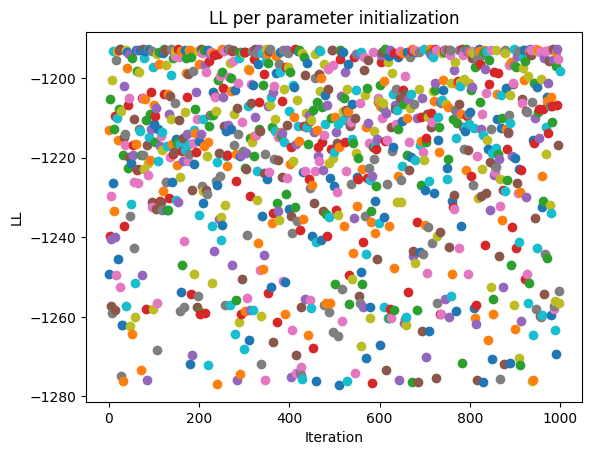

In [ ]:
# Parameter estimation for Gaussian models

best_bic = np.inf
bics = [] # For BIC plot
for n in range(5):
  best_LL = -np.inf
  best_model = None

  # Parameter estimation for n_states
  n_states = n+1
  for i in range(1000):
    model = hmm.GaussianHMM(n_components = n_states).fit(dataset)
    LL = model.score(dataset)
    # Save best scoring model
    if LL > best_LL:
        best_LL = LL
        best_model = model
    # Save iteration to plot if optimal n_states
    if n_states == 2: # replace for optimal n_states (might need to re-run)
      plt.scatter(y=LL, x=i)

  # Calculate BIC value and append for plot
  n_params = n_states * (n_states - 1) + 2 * n_states + (n_states - 1)
  n_samples = len(data)
  BIC = -2 * best_LL + n_params * np.log(n_samples)
  bics.append(BIC)

  # If BIC of n_states is lower than current best -> replace
  if BIC < best_bic:
    best_bic = BIC
    optimal_states = n_states
    optimal_model = best_model
    optimal_LL = best_LL

# Plot log-likelihood for optimal n_states
plt.title('LL per parameter initialization')
plt.xlabel('Iteration')
plt.ylabel('LL')
plt.show()

In [ ]:
# Print BIC, LL, and number of states for the optimal model
print(f'BIC: {best_bic}')
print(f'Log-likelihood: {optimal_LL}\nStates: {optimal_states}')

BIC: 2432.5914557266206
Log-likelihood: -1192.7288212418796
States: 2


In [ ]:
# Print TPM of the optimal model and mean/variance of each hidden state
print("Transition matrix")
print(optimal_model.transmat_)
print()
print("Means and variances of each hidden state")
for i in range(1, optimal_model.n_components+1):
  print(f"Hidden state {i}:")
  print(f"mean = {optimal_model.means_[i-1]}")
  print(f"var = {np.diag(optimal_model.covars_[i-1])}")
  print()

Transition matrix
[[0.95227963 0.04772037]
 [0.07108809 0.92891191]]

Means and variances of each hidden state
Hidden state 1:
mean = [0.12604054]
var = [0.43867109]

Hidden state 2:
mean = [-0.07338302]
var = [2.39868154]



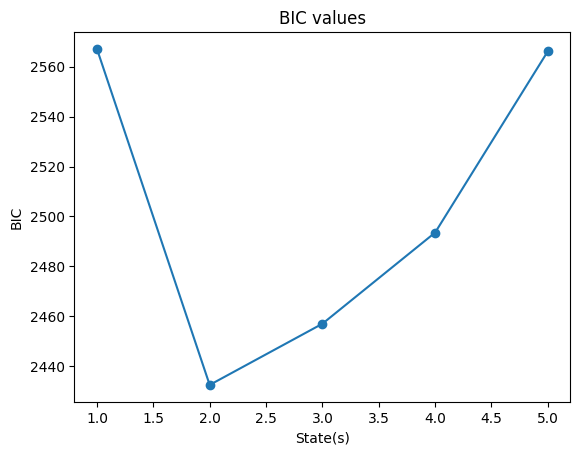

In [ ]:
# Plot BIC values for different n_states
plt.scatter(range(1,len(bics)+1), bics)
plt.plot(range(1,len(bics)+1), bics)
plt.title('BIC values')
plt.ylabel('BIC')
plt.xlabel('State(s)')
plt.show()

## Synthetic data

In [ ]:
# Define parameters
startprob = np.array([0.5, 0.5])

transmat = np.array([[0.9, 0.1],
                     [0.1, 0.9]])

emissionprob = np.array([[0.9, 0.1],
                         [0.1, 0.9]])

# Set the model parameters (for generating synthetic data)
model = hmm.CategoricalHMM(n_components = 2)
model.startprob_ = startprob
model.transmat_ = transmat
model.emissionprob_ = emissionprob

# Generate synthetic data
X, Z = model.sample(1000)
# X: 1000 long sequence of observations
# Z: 1000 long sequence of hidden states that generated X

In [ ]:
best_LL = -np.inf
best_model = None

# Parameter estimation // Parameter Recovery on synthetic data
for i in range(1000):
    new_model = hmm.CategoricalHMM(n_components = 2).fit(X)
    LL = new_model.score(X)
    # Save best scoring model
    if LL > best_LL:
        best_LL = LL
        best_model = new_model

In [ ]:
# Extract the estimated parameters
print(f'Transition Probability Matrix (TPM): \n {best_model.transmat_}')
print(f'Emission Probabilities (CPM): \n {best_model.emissionprob_}')

Transition Probability Matrix (TPM): 
 [[0.86996377 0.13003623]
 [0.11223941 0.88776059]]
Emission Probabilities (CPM): 
 [[0.89825559 0.10174441]
 [0.12575786 0.87424214]]


## Volatility proxy (SPX)

Create SPX 21 day annualized rolling volatility

In [ ]:
spx_pct = SPX.pct_change()*100
spx_pct = spx_pct[1:]
spx_vol = spx_pct.rolling(window=21).std()*(252**0.5)
spx_vol = spx_vol.dropna()

### Evaluating Parameter Recovery for rolling Volatility


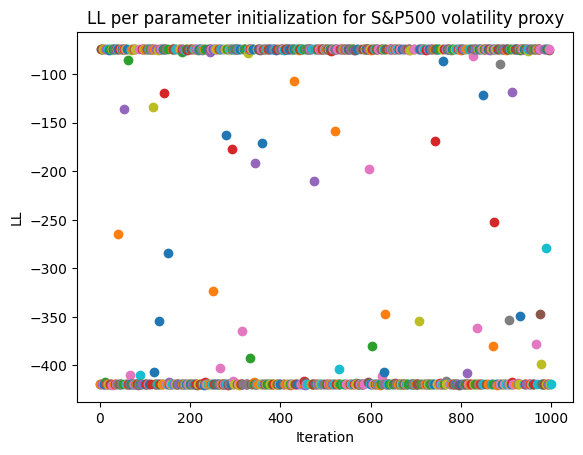


Log-likelihood: -74.04864729474501
Transition Probability Matrix (TPM): 
 [[0.99186556 0.00813444]
 [0.0298022  0.9701978 ]]
Emission Matrix: 
 [[0.99850932 0.00149068]
 [0.01757026 0.98242974]]


In [ ]:
# Data preperation on volatility proxy
spx_vol_threshold = (np.max(spx_vol)+np.min(spx_vol))*0.5
spx_vol_observations = [1 if n >= spx_vol_threshold else 0 for n in spx_vol]
spx_vol_observations = np.array(spx_vol_observations).reshape(-1, 1)

# Running Parameter Estimation on Vol Proxy
best_LL = -np.inf
best_model = None
n_states = 2
for i in range(1000):
    model = hmm.CategoricalHMM(n_components = n_states).fit(spx_vol_observations)
    LL = model.score(spx_vol_observations)
    if LL > best_LL:
        best_LL = LL
        best_model = model
    plt.scatter(x=i, y=LL)
plt.title('LL per parameter initialization for S&P500 volatility proxy')
plt.xlabel('Iteration')
plt.ylabel('LL')
plt.show()

print()
print(f'Log-likelihood: {best_LL}')
print(f'Transition Probability Matrix (TPM): \n {best_model.transmat_}')
print(f'Emission Matrix: \n {best_model.emissionprob_}')

###Plotting against VIX

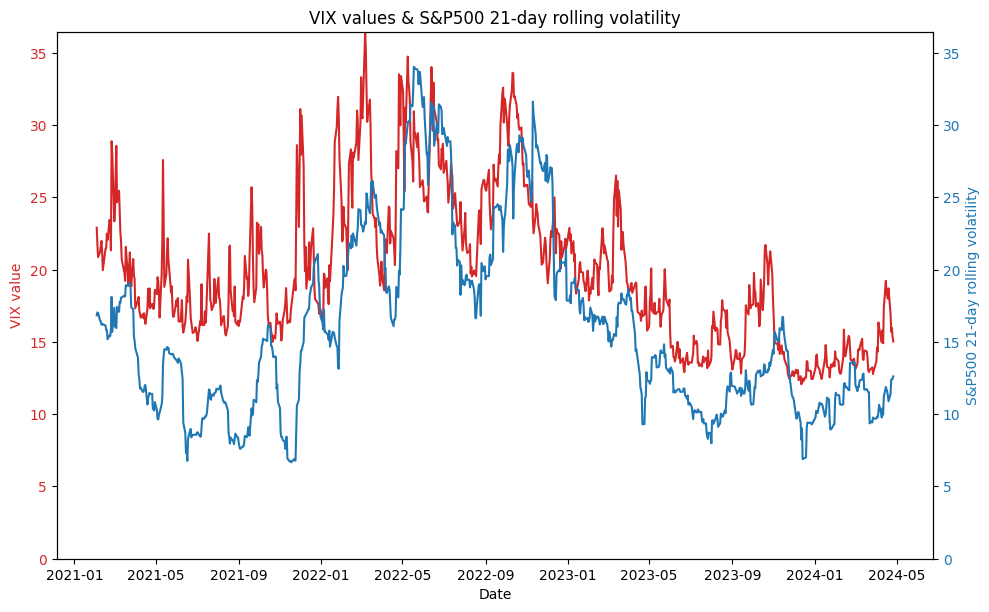

In [ ]:
# Creating the DataFrame and dropping NA
combined = pd.DataFrame({'VIX': VIX, 'SPX_Vol': spx_vol})
combined = combined.dropna()  # Drop any rows with NA in either column

# Initiate Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting VIX values
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('VIX value', color=color)
ax1.plot(combined.index, combined['VIX'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axis that shares the same x-axis

# Plotting S&P500 rolling volatility
color = 'tab:blue'
ax2.set_ylabel('S&P500 21-day rolling volatility', color=color)
ax2.plot(combined.index, combined['SPX_Vol'], color=color)
ax2.tick_params(axis='y', labelcolor=color)


# Determine the range of VIX and SPX_Vol
vix_range = (combined['VIX'].min(), combined['VIX'].max())
spx_range = (combined['SPX_Vol'].min(), combined['SPX_Vol'].max())

# Set first y-axis limits based on observed ranges
ax1.set_ylim([0, max(vix_range[1], spx_range[1])])  # Making the max limit the higher of the two maxima

# Set second y-axis the same as the first limits for coherence
ax2.set_ylim([0, max(vix_range[1], spx_range[1])])

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('VIX values & S&P500 21-day rolling volatility')

# Showcase Plot
plt.show()